In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from Backtesting import BacktesterData, FilingBacktester

In [365]:
bt_data = BacktesterData(
    holdings_path='Output/holdings.csv',
    sec_master_path='Output/security_master.csv',
    sec_mapping_path='Output/security_mapping.csv',
    sec_out_path='Output/security_out.csv',
    managers_path='Input/managers.xlsx'
)

      holding_date   holder_CIQ  security_CIQ   shares      value position_date          CIQ    Master                                    Name            ISIN                          Industry is_biotech    Ticker PX_NA_Flag Min_Px_Date Max_Px_Date
45099   2014-12-31  IQ168064993       IQ29753   410100   75.69626    2014-12-31  IQ168064993  Duquesne                          Illumina, Inc.  I_US4523271090  Life Sciences Tools and Services       True   ILMN US      False  2009-12-31  2025-03-31
45101   2014-12-31  IQ168064993       IQ29929   655000   10.15250    2014-12-31  IQ168064993  Duquesne                     Nektar Therapeutics  I_US6402681083                   Pharmaceuticals       True   NKTR US      False  2009-12-31  2025-03-31
45105   2014-12-31  IQ168064993       IQ29726   359400  121.99833    2014-12-31  IQ168064993  Duquesne                             Biogen Inc.  I_US09062X1037                     Biotechnology       True   BIIB US      False  2009-12-31  2025-03-31
4510

In [775]:
bt = FilingBacktester(bt_data)

In [53]:
consolidated_error_df = bt.error_df.groupby(['Ticker', 'Name']).agg({
    'holding_date': ['min', 'max'],
    'value': 'sum'
}).reset_index()
consolidated_error_df.columns = ['Ticker', 'Name', 'min_holding_date', 'max_holding_date', 'value']
consolidated_error_df = consolidated_error_df.sort_values('value', ascending=False)

# Exclude securities I have already verified are from erroneus filings
excluded_tickers = ['SVA US', #Private, reported holdings values are stale
                    'DCPH US', #Acquired
                    'BLU CN', #Acquired
                    'ZGNX US', #Acquired
                    '1284849DUS', #Acquired
                    'ALPN US', #Acquired
                    'PRXL US', #Delisted
                    'QP/ LN', #Private
                    ]
consolidated_error_df = consolidated_error_df[~consolidated_error_df['Ticker'].isin(excluded_tickers)]

print("Top errors by value:")
# Set display options to show more rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(consolidated_error_df)

Top errors by value:
        Ticker                                          Name min_holding_date max_holding_date      value
58     VYNE US                        VYNE Therapeutics Inc.       2014-12-31       2017-12-31  661.76392
35     NEUP US                   Neuphoria Therapeutics Inc.       2017-06-30       2021-09-30  226.42897
60     ZCOR US                            Zyla Life Sciences       2014-12-31       2018-12-31  114.06768
2   1891847DUS                 Centrexion Therapeutics Corp.       2018-03-31       2024-12-31   95.24072
56     VRNA US                             Verona Pharma plc       2014-12-31       2017-03-31   92.45430
47     SLGC US                      CM Life Sciences II Inc.       2021-03-31       2021-03-31   66.71428
23     FLAC US  Frazier Lifesciences Acquisition Corporation       2020-12-31       2020-12-31   57.64533
39    PRGBQ US                Protea Biosciences Group, Inc.       2021-12-31       2022-03-31   43.70166
19     CERE US           

In [52]:
print(bt.error_df[~bt.error_df['Ticker'].isin(excluded_tickers)].sort_values('value', ascending=False))

       holding_date         Master      Ticker     value                                          Name PX_NA_Flag Max_Px_Date Min_Px_Date
58420    2016-12-31    Great Point     VYNE US  33.30000                        VYNE Therapeutics Inc.      False  2025-03-31  2018-01-24
58566    2017-12-31    Great Point     VYNE US  28.73807                        VYNE Therapeutics Inc.      False  2025-03-31  2018-01-24
71451    2024-06-30     Krensavage     TARO US  27.95400           Taro Pharmaceutical Industries Ltd.      False  2024-06-21  2009-12-31
16157    2016-12-31     Baker Bros     VYNE US  27.38039                        VYNE Therapeutics Inc.      False  2025-03-31  2018-01-24
58530    2017-09-30    Great Point     VYNE US  26.53848                        VYNE Therapeutics Inc.      False  2025-03-31  2018-01-24
105805   2022-12-31            RTW     OYST US  25.74659                     Oyster Point Pharma, Inc.      False  2022-12-30  2019-10-30
58387    2016-09-30    Great Point

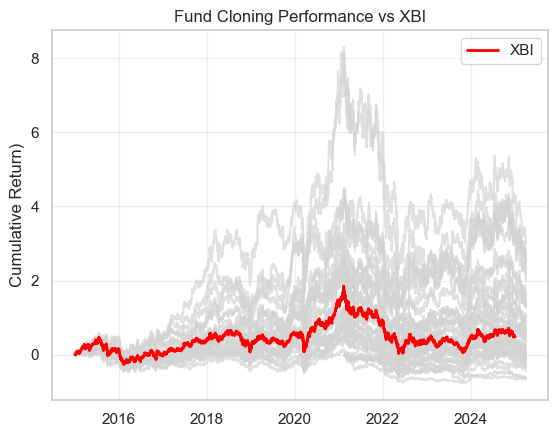

In [696]:
xbi = bt.sec_rets_df['XBI US'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2024-12-31')]
xbi_cum_perf = (1+xbi).cumprod()-1

# Create a dictionary to store fund performance for later reference
fund_performances = {}

# Plot each fund in light grey with no labels
for fund in bt.manager_df[~(bt.manager_df['Public_Start'].isna() | bt.manager_df['Public_End'].isna() | bt.manager_df['Contamination'] | bt.manager_df['Not_Biotech'])]['Master'].unique():
    holdings = bt.get_fund_holdings(fund, contamination = bt.manager_df.loc[bt.manager_df['Master'] == fund, 'Contamination'].values[0])
    holdings = bt.adjust_holdings(holdings, max_participation=0.1, port_size=10000000, pct=0.999)
    # Add 45 days to the holdings index to account for filing delay
    holdings.index = holdings.index + pd.Timedelta(days=45)
    perf = bt.get_strategy_returns(holdings, max(holdings.index)+pd.Timedelta(days=90))
    
    # Replace NaN values with 0 to avoid issues in cumulative performance calculation
    perf = perf.fillna(0)
    cum_perf = (1+perf).cumprod()-1
    
    # Store just the performance in the dictionary
    fund_performances[fund] = perf
    
    plt.plot(cum_perf, color='lightgrey', alpha=0.7)

# Add XBI in red with a label
plt.plot(xbi_cum_perf, color='red', linewidth=2, label='XBI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Fund Cloning Performance vs XBI')
plt.ylabel('Cumulative Return)')
plt.show()

In [743]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

HALF_LIFE = 365*2

xbi = bt.sec_rets_df['XBI US'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2025-03-31')]

quarter_ends = pd.date_range(
    start=pd.Timestamp('2014-12-31'),
    end=pd.Timestamp('2024-12-31'),
    freq='QE'  # Quarter end frequency (updated from 'Q')
)
quarter_ends_delayed = [date + pd.Timedelta(days=45) for date in quarter_ends]

# Create a DataFrame to store all IR values
all_ir_data = []

for date in quarter_ends_delayed:
    for fund in fund_performances:
        if date - pd.Timedelta(days=365) not in fund_performances[fund].index or (date >= max(fund_performances[fund].index)):
            continue

        cur_fund_perf = fund_performances[fund].loc[:date]
        xbi_perf = xbi.loc[cur_fund_perf.index]
        # Join XBI performance to fund performance
        combined_perf = pd.DataFrame({
            'fund': cur_fund_perf,
            'xbi': xbi_perf
        })
        # Drop rows where either fund or XBI performance is exactly 0
        combined_perf = combined_perf[(combined_perf['fund'] != 0) & (combined_perf['xbi'] != 0)]
        # Calculate exponential weights with a half-life of 255 days
        days_diff = (date - combined_perf.index).days
        combined_perf['Weight'] = np.exp(-np.log(2) * days_diff / HALF_LIFE)

        try:
            model = sm.WLS(combined_perf['fund'], sm.add_constant(combined_perf['xbi']), weights=combined_perf['Weight'])
            results = model.fit()
        except:
            print(f"Error fitting model for {fund} on {date}")
            continue

        daily_vol = np.sqrt(np.sum(combined_perf['Weight'] * results.resid**2)/np.sum(combined_perf['Weight']))
        daily_alpha = np.sum(results.resid * combined_perf['Weight'])/np.sum(combined_perf['Weight']) + results.params.iloc[0]

        quarter_daily_vol = np.std(results.resid[results.resid.index >= date - pd.Timedelta(days=90)])
        quarter_daily_alpha = np.mean(results.resid[results.resid.index >= date - pd.Timedelta(days=90)] + results.params.iloc[0])
        
        # Add to our list of IR data
        all_ir_data.append({
            'date': date,
            'fund': fund,
            'ir': daily_alpha/daily_vol,
            'daily_vol_projected': daily_vol,
            'daily_alpha_projected': daily_alpha,
            'quarter_daily_vol': quarter_daily_vol,
            'quarter_daily_alpha': quarter_daily_alpha
        })

# Convert the list to a DataFrame
ir_df = pd.DataFrame(all_ir_data)

In [748]:
# Filter out negative IR values
ir_df.loc[ir_df['ir'] < 0, 'ir'] = 0

# Group by date and calculate the sum of positive IR values for each date
ir_sum = ir_df.groupby('date')['ir'].sum()

ir_df['ir_sum'] = ir_df['date'].map(ir_sum)

ir_df['weight'] = ir_df['ir'] / ir_df['ir_sum']

# Create a blank DataFrame with all securities from sec_rets_df and all dates from ir_df
all_dates = ir_df['date'].unique()
all_securities = bt.sec_rets_df.columns.tolist()
final_holdings = pd.DataFrame(0.0, index=all_dates, columns=all_securities)
fund_holdings = {}


for fund in ir_df['fund'].unique():
    fund_holdings[fund] = bt.get_fund_holdings(fund)
    fund_holdings[fund].index = fund_holdings[fund].index + pd.Timedelta(days=45)

for date in all_dates:
    # Get the funds and their weights for that date
    funds_on_date = ir_df[ir_df['date'] == date]
    for fund, weight in zip(funds_on_date['fund'], funds_on_date['weight']):
        # Only add values for columns that exist in both DataFrames
        columns = fund_holdings[fund].columns
        final_holdings.loc[date, columns] += fund_holdings[fund].loc[date, columns] * weight

final_holdings = bt.adjust_holdings(final_holdings, max_participation=0.1, port_size=100000000, n=100)

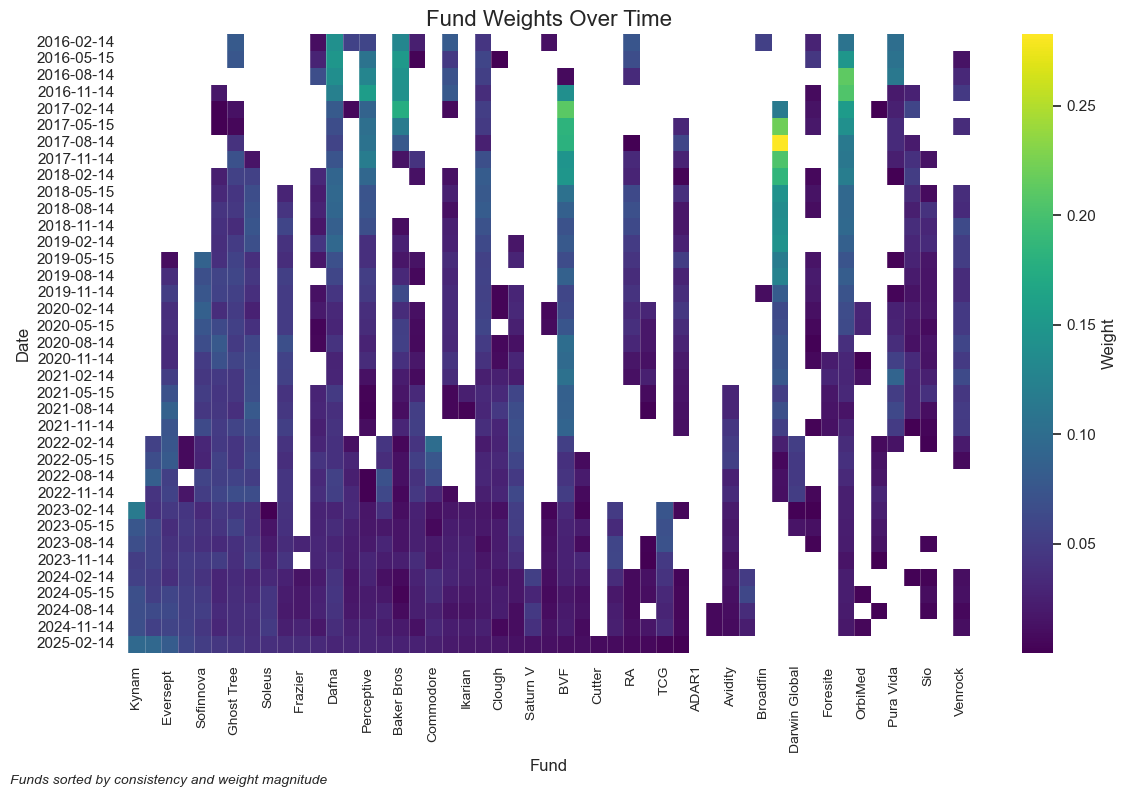

In [749]:
weight_pivot = ir_df.pivot(index='date', columns='fund', values='weight')
# Replace zeros with NaN for better visualization
weight_pivot = weight_pivot.replace(0, np.nan)

most_recent_date = weight_pivot.index.max()

most_recent_weights = weight_pivot.loc[most_recent_date]
sorted_funds = most_recent_weights.sort_values(ascending=False).index
weight_pivot = weight_pivot[sorted_funds]

# Create a better color map that makes the pattern more visible
custom_cmap = sns.color_palette("viridis", as_cmap=True)

# Plot - Regular weights
plt.figure(figsize=(12, 8))
ax1 = sns.heatmap(weight_pivot, cmap=custom_cmap, cbar_kws={'label': 'Weight'})

plt.title('Fund Weights Over Time', fontsize=16)
plt.xlabel('Fund', fontsize=12)
plt.ylabel('Date', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=10)

# Format dates on y-axis
date_format = plt.matplotlib.dates.DateFormatter('%Y-%m-%d')
ax1.yaxis.set_major_formatter(date_format)
plt.yticks(ticks=plt.yticks()[0], labels=[d.strftime('%Y-%m-%d') for d in weight_pivot.index])

# Add grid lines to make it easier to track across the chart
ax1.grid(False)  # Turn off the default grid
for i in range(len(sorted_funds)):
    plt.axvline(x=i, color='white', linewidth=0.5, alpha=0.3)

# Add a descriptive annotation
plt.figtext(0.01, 0.01, "Funds sorted by consistency and weight magnitude", 
            fontsize=10, style='italic')

plt.tight_layout()
plt.show()


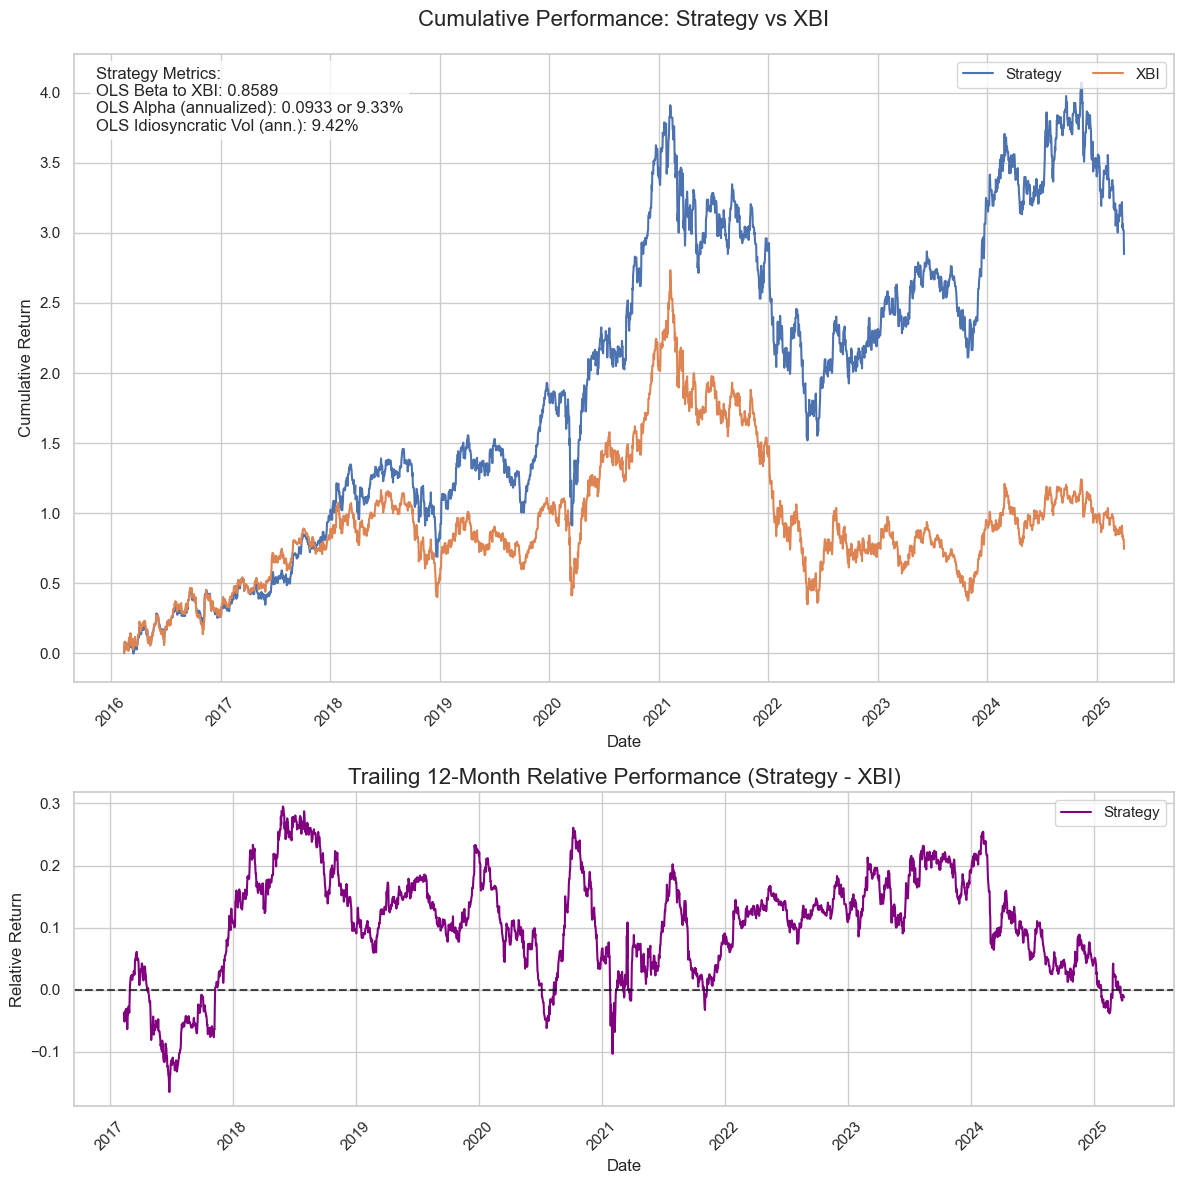

In [750]:
# Get strategy returns and XBI returns
strategy_returns = bt.get_strategy_returns(final_holdings, pd.Timestamp('2025-03-31'))
xbi_returns = bt.sec_rets_df['XBI US'].loc[strategy_returns.index[0]:strategy_returns.index[-1]]

# Convert to cumulative returns
strategy_cumulative = (1 + strategy_returns).cumprod() - 1
xbi_cumulative = (1 + xbi_returns).cumprod() - 1

# Create a DataFrame for plotting
cumulative_returns = pd.DataFrame({
    'Strategy': strategy_cumulative,
    'XBI': xbi_cumulative
})

# Calculate trailing 12-month cumulative returns for both strategy and XBI
strategy_t12m = (1 + strategy_returns).rolling(window=365).apply(lambda x: x.prod()) - 1
xbi_t12m = (1 + xbi_returns).rolling(window=365).apply(lambda x: x.prod()) - 1

# Calculate trailing 12-month relative performance (Strategy T12M - XBI T12M)
trailing_12m_relative = strategy_t12m - xbi_t12m

# Import required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Compute beta and alpha to XBI for regular strategy
returns_for_regression = pd.DataFrame({
    'strategy': strategy_returns,
    'xbi': xbi_returns
})
returns_for_regression = returns_for_regression.dropna()
returns_for_regression = returns_for_regression[(returns_for_regression['strategy'] != 0) | 
                                               (returns_for_regression['xbi'] != 0)]

# Add a constant to the regression model
X = sm.add_constant(returns_for_regression['xbi'])
Y = returns_for_regression['strategy']

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Extract beta and alpha
beta = model.params['xbi']
alpha = model.params['const']
alpha_annualized = alpha * len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25)

idio_vol = model.resid.std()
idio_vol_annualized = idio_vol * np.sqrt(len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25))

# Plot 1: Cumulative Performance
sns.set_style("whitegrid")
sns.lineplot(data=cumulative_returns, dashes=False, ax=ax1)
ax1.set_title("Cumulative Performance: Strategy vs XBI", fontsize=16, pad=20)  # Add padding to the title
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Cumulative Return", fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title="", loc='upper right', ncol=2)  # Move legend to upper right

# Add text box with metrics to the top left corner of the main plot
metrics_text = (f"Strategy Metrics:\n"
                f"OLS Beta to XBI: {beta:.4f}\n"
                f"OLS Alpha (annualized): {alpha_annualized:.4f} or {alpha_annualized*100:.2f}%\n"
                f"OLS Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%")

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Trailing 12-month Relative Performance
sns.lineplot(data=trailing_12m_relative, color='purple', label='Strategy', ax=ax2)
ax2.set_title("Trailing 12-Month Relative Performance (Strategy - XBI)", fontsize=16)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Relative Return", fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.legend(title="", loc='best')

plt.tight_layout()
plt.show()


In [722]:
# Get the holdings for the specified date
holdings = final_holdings.loc[pd.Timestamp('2025-02-14')].dropna().loc[lambda x: x != 0]
# Sort by size (value) in descending order
sorted_holdings = holdings.sort_values(ascending=False)
# Convert to percentage and print the sorted holdings
percentage_holdings = sorted_holdings * 100
print(percentage_holdings)

# Calculate and print average, max, and min weights across all dates
hhi = (1/(final_holdings**2).sum(axis=1))
max_weight = final_holdings.max().max() * 100
print(f"Avg Effective Concentration: {hhi.mean():.2f}")
print(f"Minimum Effective Concentration: {hhi.min():.2f}")
print(f"Average max weight: {final_holdings.max(axis=1).mean()*100:.2f}%")
print(f"Maximum weight across all dates: {max_weight:.2f}%")


NTRA US     8.113753
ARGX BB     3.333929
PCVX US     2.837917
GSK LN      2.245972
TEVA IT     2.178093
JAZZ US     2.144925
MDGL US     2.129164
MRUS US     1.945429
VRNA US     1.942768
AXSM US     1.897614
VERA US     1.889691
XENE US     1.884907
ASND US     1.868269
INSM US     1.767498
SNDX US     1.618132
SRPT US     1.417319
MLTX US     1.379700
CRNX US     1.368349
NAMS US     1.366536
CLDX US     1.349477
CNTA US     1.332285
JANX US     1.324281
UTHR US     1.319178
LLY US      1.245018
ALKS US     1.207515
PTCT US     1.193457
VRDN US     1.141087
CGON US     1.101209
INCY US     1.095948
TARS US     1.037085
ACLX US     0.990273
RARE US     0.949169
BCRX US     0.936213
NOVOB DC    0.924222
PTGX US     0.916951
RVMD US     0.910457
NUVL US     0.904237
COGT US     0.884674
ICLR US     0.880103
EWTX US     0.877342
SLNO US     0.873290
RYTM US     0.868483
VTRS US     0.842085
STVN US     0.817528
KRYS US     0.802203
BPMC US     0.784956
DVAX US     0.771097
WVE US      0

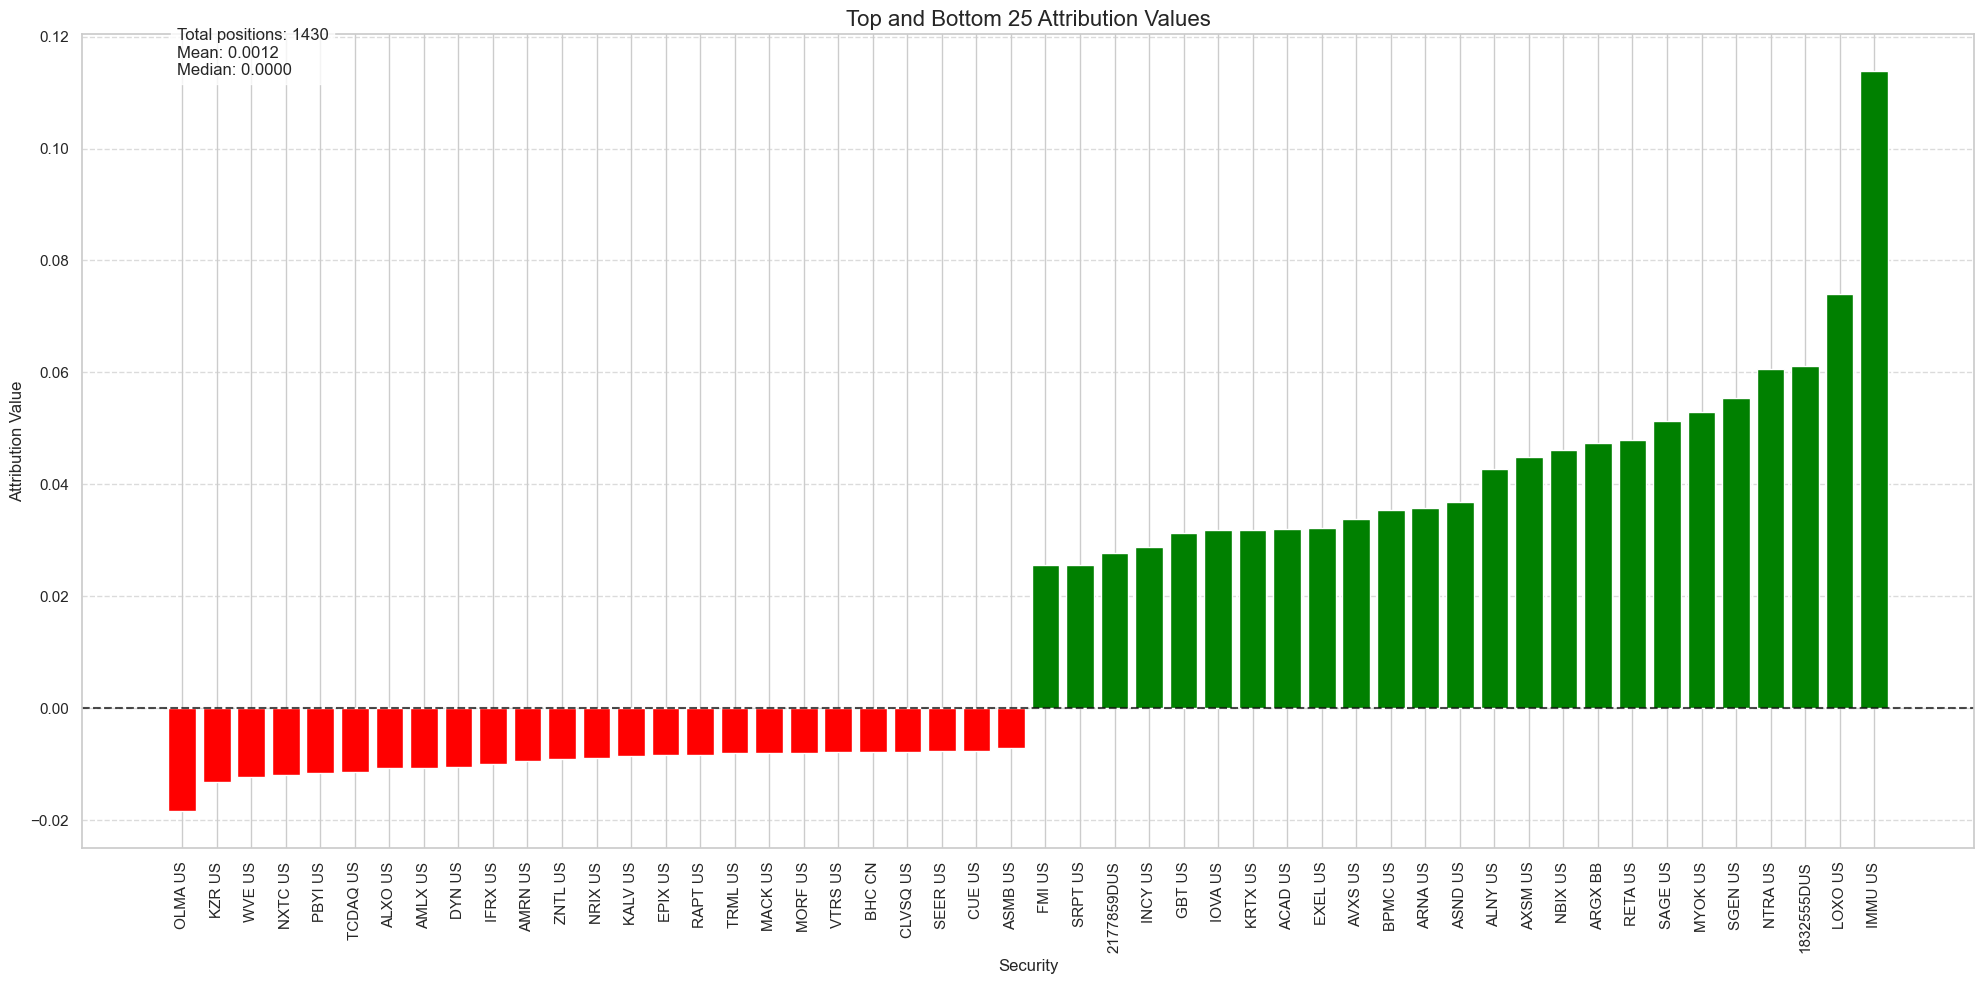

In [715]:
attr = bt.get_strategy_attribution(final_holdings, end_date=pd.Timestamp('2025-03-31'))

# Sort all attribution values from smallest to largest
plot_data = attr.sort_values()

# Get the bottom 25 and top 25 attributions
bottom_25 = plot_data.head(25)
top_25 = plot_data.tail(25)

# Combine them into a single dataframe for plotting
combined_data = pd.concat([bottom_25, top_25])

# Create a bar plot for the top and bottom 25 attributions with wider figure
plt.figure(figsize=(20, 10))
bars = plt.bar(combined_data.index, combined_data.values, color=['red' if x < 0 else 'green' for x in combined_data.values])

# Add labels and title
plt.title('Top and Bottom 25 Attribution Values', fontsize=16)
plt.xlabel('Security', fontsize=12)
plt.ylabel('Attribution Value', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add summary statistics as text
plt.text(0.05, 0.95, f"Total positions: {len(attr)}\nMean: {plot_data.mean():.4f}\nMedian: {plot_data.median():.4f}", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_47460\1721394418.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_47460\1721394418.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]


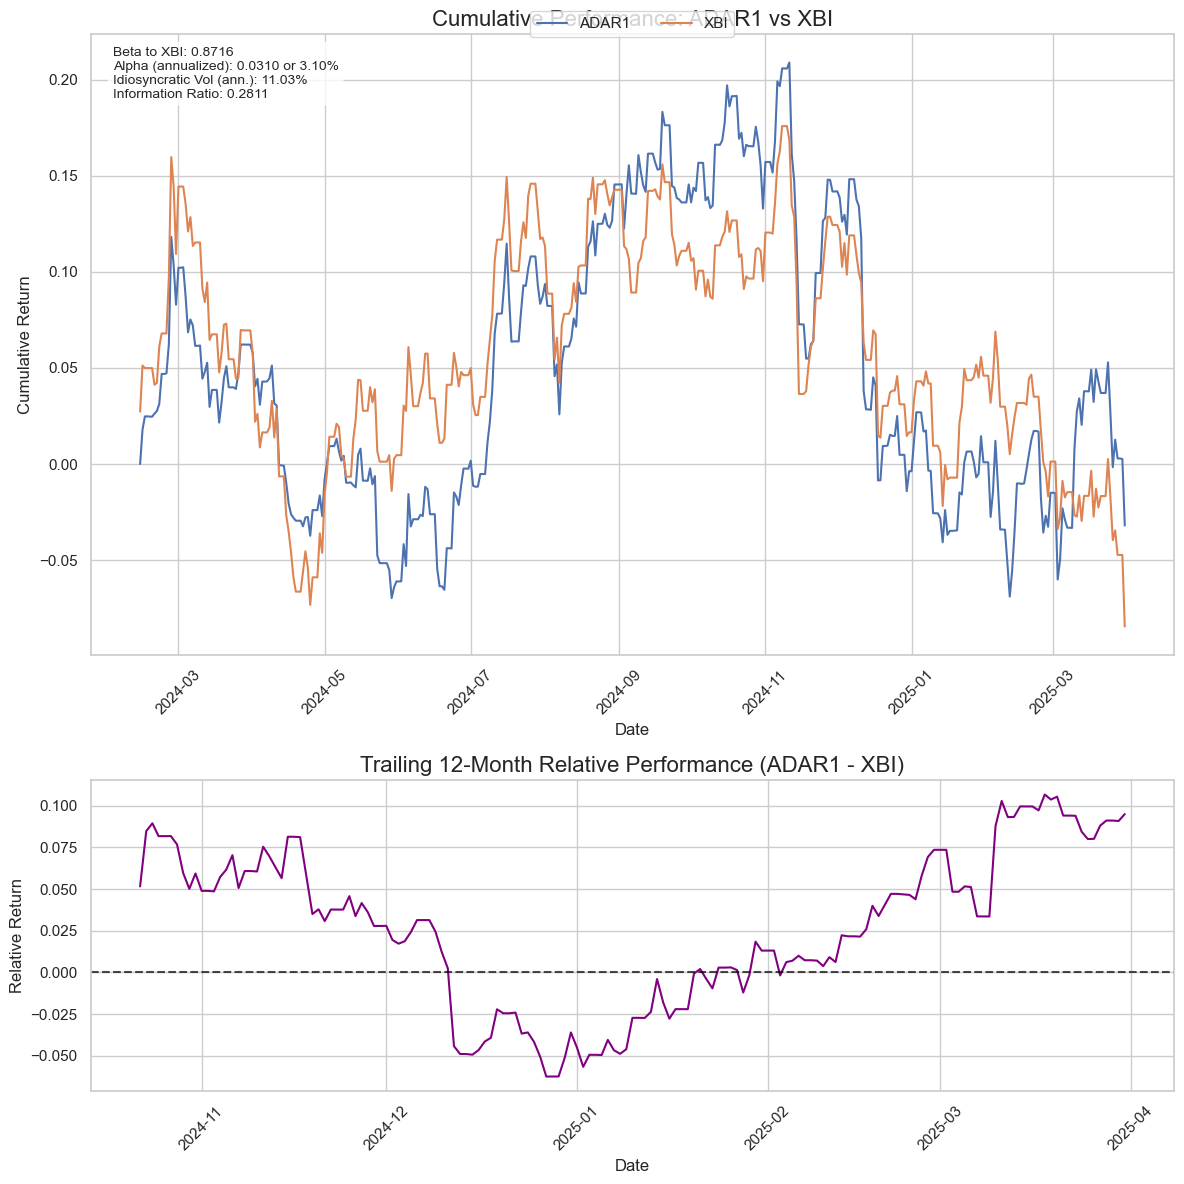

In [714]:
# Set the Master fund to analyze
master_fund = "ADAR1"  # Change this to the fund you want to analyze

# Get the fund's holdings
holdings = bt.get_fund_holdings(master_fund, contamination=False)
holdings = bt.adjust_holdings(holdings, max_participation=0.1, port_size=10000000)
# Add 45 days to the holdings index to account for filing delay
holdings.index = holdings.index + pd.Timedelta(days=45)
perf = bt.get_strategy_returns(holdings, max(holdings.index)+pd.Timedelta(days=90))

# Get XBI returns for comparison
xbi = bt.sec_rets_df['XBI US'].loc[perf.index[0]:perf.index[-1]]
xbi_cum_perf = (1+xbi).cumprod()-1

# Replace NaN values with 0 to avoid issues in cumulative performance calculation
perf = perf.fillna(0)
cum_perf = (1+perf).cumprod()-1

# Calculate trailing 12-month relative performance
trailing_12m = pd.DataFrame({
    master_fund: perf.rolling(252).sum(),
    'XBI': xbi.rolling(252).sum()
})
trailing_12m_relative = trailing_12m[master_fund] - trailing_12m['XBI']

# Calculate regression metrics
X = sm.add_constant(xbi)
model = sm.OLS(perf, X).fit()
beta = model.params[1]
alpha = model.params[0]
alpha_annualized = alpha * 252
idio_vol = np.std(model.resid)
idio_vol_annualized = idio_vol * np.sqrt(252)
information_ratio = alpha_annualized / idio_vol_annualized

# Create a DataFrame for cumulative returns
cumulative_returns = pd.DataFrame({
    master_fund: cum_perf,
    'XBI': xbi_cum_perf
})

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Cumulative Performance
sns.set_style("whitegrid")
sns.lineplot(data=cumulative_returns, dashes=False, ax=ax1)
ax1.set_title(f"Cumulative Performance: {master_fund} vs XBI", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Cumulative Return", fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title="", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

# Add text box with metrics to the top left corner of the main plot
metrics_text = (f"Beta to XBI: {beta:.4f}\n"
                f"Alpha (annualized): {alpha_annualized:.4f} or {alpha_annualized*100:.2f}%\n"
                f"Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%\n"
                f"Information Ratio: {information_ratio:.4f}")

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Trailing 12-month Relative Performance
sns.lineplot(data=trailing_12m_relative, color='purple', ax=ax2)
ax2.set_title(f"Trailing 12-Month Relative Performance ({master_fund} - XBI)", fontsize=16)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Relative Return", fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

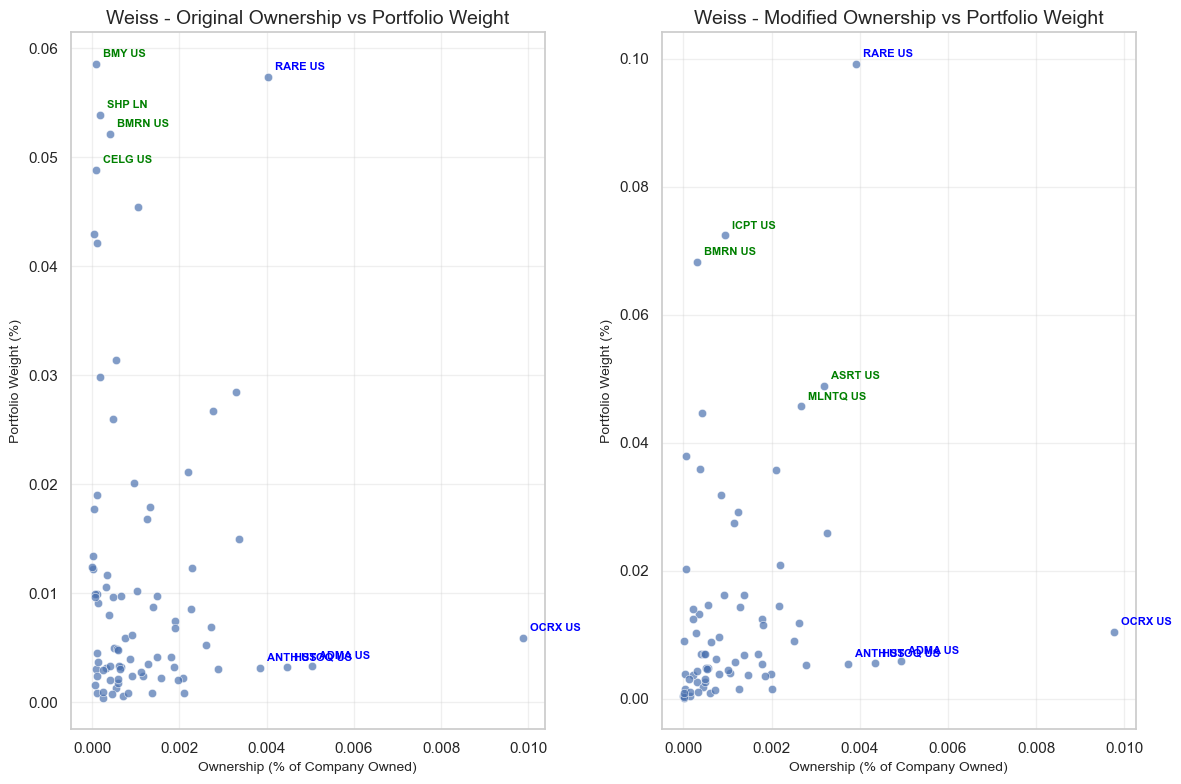

In [537]:
Master = "Weiss"

holdings_mv = bt.get_fund_holdings(Master, mvs=True)
holdings_pct = bt.get_fund_holdings(Master, mvs=False)
holdings_modified_mv = bt.get_fund_holdings(Master, mvs=True, contamination=True)
holdings_modified_pct = bt.get_fund_holdings(Master, mvs=False, contamination=True)

mkt_cap = bt.sec_mkt_cap_df.reindex(index=holdings_mv.index, columns=holdings_mv.columns)
ownership = holdings_mv.div(mkt_cap)
ownership_modified = holdings_modified_mv.div(mkt_cap)

mean_ownership = ownership.sum(axis=1)/mkt_cap.sum(axis=1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Get the latest data for both original ownership and percentage holdings
latest_ownership = ownership.iloc[-1].reset_index()
latest_ownership.columns = ['Ticker', 'Ownership']

latest_pct = holdings_pct.iloc[-1].reset_index()
latest_pct.columns = ['Ticker', 'Percentage']

# Merge the two dataframes for original data
scatter_data_original = pd.merge(latest_ownership, latest_pct, on='Ticker')
scatter_data_original = scatter_data_original.dropna()
scatter_data_original = scatter_data_original[(scatter_data_original['Ownership'] > 0) & (scatter_data_original['Percentage'] > 0)]

# Get the latest data for modified ownership and percentage holdings
latest_modified_ownership = ownership_modified.iloc[-1].reset_index()
latest_modified_ownership.columns = ['Ticker', 'Modified_Ownership']

latest_modified_pct = holdings_modified_pct.iloc[-1].reset_index()
latest_modified_pct.columns = ['Ticker', 'Modified_Percentage']

# Merge the two dataframes for modified data
scatter_data_modified = pd.merge(latest_modified_ownership, latest_modified_pct, on='Ticker')
scatter_data_modified = scatter_data_modified.dropna()
scatter_data_modified = scatter_data_modified[(scatter_data_modified['Modified_Ownership'] > 0) & (scatter_data_modified['Modified_Percentage'] > 0)]

# Get top 5 highest ownership and percentage names for both datasets
top_5_ownership_original = scatter_data_original.sort_values('Ownership', ascending=False).head(5)
top_5_pct_original = scatter_data_original.sort_values('Percentage', ascending=False).head(5)

top_5_ownership_modified = scatter_data_modified.sort_values('Modified_Ownership', ascending=False).head(5)
top_5_pct_modified = scatter_data_modified.sort_values('Modified_Percentage', ascending=False).head(5)

# Plot 1: Original Data
sns.scatterplot(data=scatter_data_original, x='Ownership', y='Percentage', alpha=0.7, ax=ax1)

# Label top points in original plot
for _, row in top_5_ownership_original.iterrows():
    ax1.annotate(row['Ticker'], 
                xy=(row['Ownership'], row['Percentage']),
                xytext=(5, 5),
                textcoords='offset points',
                color='blue',
                fontweight='bold',
                fontsize=8)

for _, row in top_5_pct_original.iterrows():
    if row['Ticker'] not in top_5_ownership_original['Ticker'].values:
        ax1.annotate(row['Ticker'], 
                    xy=(row['Ownership'], row['Percentage']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color='green',
                    fontweight='bold',
                    fontsize=8)

ax1.set_title(f"{Master} - Original Ownership vs Portfolio Weight", fontsize=14)
ax1.set_xlabel("Ownership (% of Company Owned)", fontsize=10)
ax1.set_ylabel("Portfolio Weight (%)", fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Modified Data
sns.scatterplot(data=scatter_data_modified, x='Modified_Ownership', y='Modified_Percentage', alpha=0.7, ax=ax2)

# Label top points in modified plot
for _, row in top_5_ownership_modified.iterrows():
    ax2.annotate(row['Ticker'], 
                xy=(row['Modified_Ownership'], row['Modified_Percentage']),
                xytext=(5, 5),
                textcoords='offset points',
                color='blue',
                fontweight='bold',
                fontsize=8)

for _, row in top_5_pct_modified.iterrows():
    if row['Ticker'] not in top_5_ownership_modified['Ticker'].values:
        ax2.annotate(row['Ticker'], 
                    xy=(row['Modified_Ownership'], row['Modified_Percentage']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color='green',
                    fontweight='bold',
                    fontsize=8)

ax2.set_title(f"{Master} - Modified Ownership vs Portfolio Weight", fontsize=14)
ax2.set_xlabel("Ownership (% of Company Owned)", fontsize=10)
ax2.set_ylabel("Portfolio Weight (%)", fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


First date in holdings: 2014-12-31 00:00:00


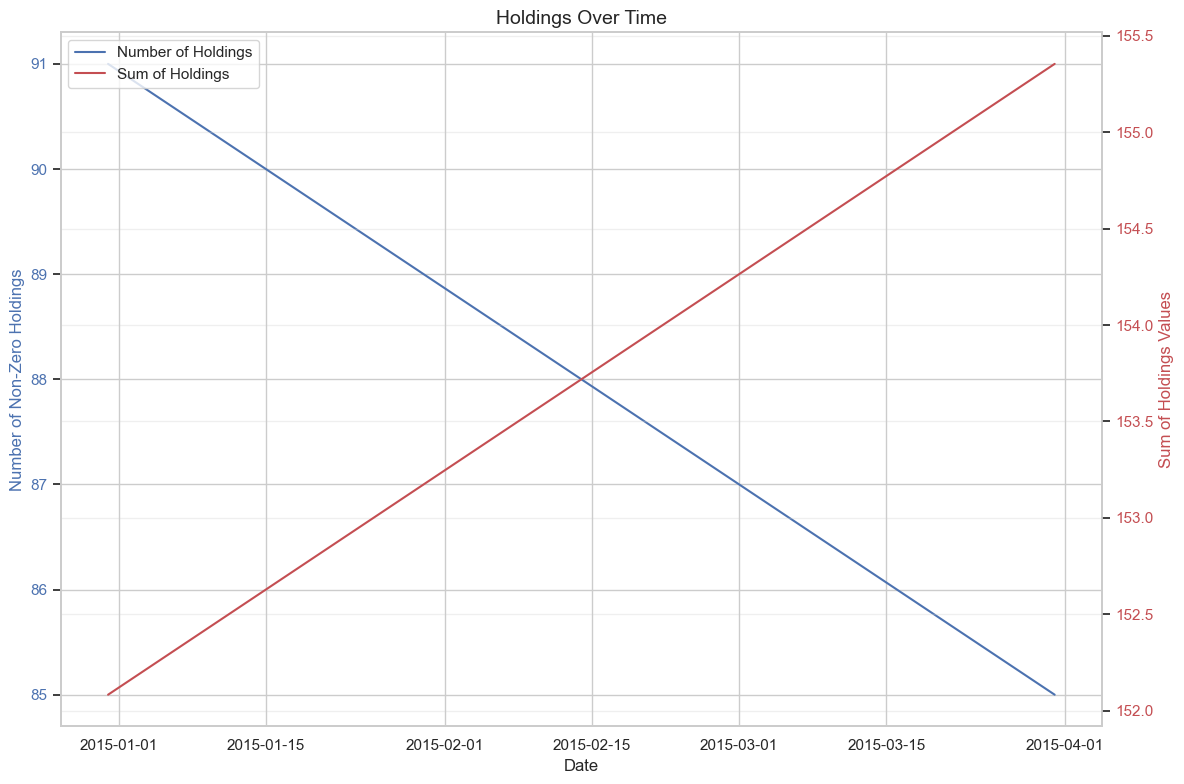

In [ ]:
# Get the fund holdings
holdings = bt.get_fund_holdings(Master, mvs=True)

# Count non-zero columns per row
nonzero_counts = holdings.astype(bool).sum(axis=1)

# Calculate sum of holdings values
holdings_sum = holdings.sum(axis=1)

# Display the first date in the holdings
first_date = holdings.index[0]
print(f"First date in holdings: {first_date}")

# Plot the counts and sum
fig, ax1 = plt.subplots(figsize=(1200/100, 800/100))

# Plot number of holdings
ax1.plot(nonzero_counts.index, nonzero_counts.values, 'b-', label='Number of Holdings')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Number of Non-Zero Holdings", fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis for sum
ax2 = ax1.twinx()
ax2.plot(holdings_sum.index, holdings_sum.values, 'r-', label='Sum of Holdings')
ax2.set_ylabel("Sum of Holdings Values", fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Holdings Over Time", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [771]:
mkt_cap = bt.sec_mkt_cap_df
eligible = bt.eligible_securities_df
rets = bt.sec_rets_df
valid_rets = (rets == 0).sum(axis=1) < 0.9*len(rets.columns)

mkt_cap = mkt_cap.loc[valid_rets]
mkt_cap = mkt_cap.multiply(eligible)
mkt_cap = mkt_cap.replace(0, np.nan)
rets = rets.loc[valid_rets]

# Size
size_score = np.log(mkt_cap)
size_score = bt.standardize_factor_scores(size_score)

# Separate Reversal (short-term) and Momentum (long-term) factors
MOMENTUM_LONG_PERIOD = 252 #~1 year
REVERSAL_PERIOD = 21 #~1 month

# Long-term momentum component
# Calculate returns excluding the most recent REVERSAL_PERIOD (21 days)
# and including only the period from t-MOMENTUM_LONG_PERIOD to t-REVERSAL_PERIOD
momentum_score = np.log(rets+1).shift(REVERSAL_PERIOD).rolling(window=MOMENTUM_LONG_PERIOD-REVERSAL_PERIOD, min_periods=63).mean().fillna(0)
momentum_score = bt.standardize_factor_scores(momentum_score)

# Short-term reversal component (negative of short-term returns)
reversal_score = -np.log(rets+1).ewm(halflife=REVERSAL_PERIOD, adjust=True).mean()
reversal_score = bt.standardize_factor_scores(reversal_score)

# Create DataFrames to store regression results
regression_results = pd.DataFrame(index=rets.index[MOMENTUM_LONG_PERIOD+1:], 
                                 columns=['Size_Factor_Return', 'Momentum_Factor_Return', 
                                          'Reversal_Factor_Return', 'Market_Factor_Return', 'R_Squared',
                                          'Size_T_Stat', 'Momentum_T_Stat', 'Reversal_T_Stat', 'Market_T_Stat'])

# Loop through each day in rets
for i in range(MOMENTUM_LONG_PERIOD+1, len(rets)):
    # Get data for the current date
    date = rets.index[i]
    previous_date = rets.index[i-1]
    day_rets = rets.loc[date]
    day_size_score = size_score.loc[previous_date]
    day_momentum_score = momentum_score.loc[previous_date]
    day_reversal_score = reversal_score.loc[previous_date]
    day_mkt_cap = mkt_cap.loc[previous_date]

    if (day_rets == 0).sum() > 0.9*len(day_rets):
        continue
    
    # Filter out NaN values (keep only where all values are available)
    mask = ~(np.isnan(day_rets) | np.isnan(day_size_score) | 
             np.isnan(day_momentum_score) | np.isnan(day_reversal_score) | 
             np.isnan(day_mkt_cap))
    
    filtered_rets = day_rets[mask]
    filtered_rets.name = 'rets'
    filtered_rets = filtered_rets.clip(filtered_rets.mean()-4*filtered_rets.std(), 
                                       filtered_rets.mean()+4*filtered_rets.std())

    filtered_size_score = day_size_score[mask]
    filtered_size_score.name = 'size_score'
    filtered_momentum_score = day_momentum_score[mask]
    filtered_momentum_score.name = 'momentum_score'
    filtered_reversal_score = day_reversal_score[mask]
    filtered_reversal_score.name = 'reversal_score'
    filtered_mkt_cap = day_mkt_cap[mask]
    filtered_mkt_cap.name = 'mkt_cap'

    # Prepare data for regression (add constant for intercept)
    X = sm.add_constant(pd.DataFrame({
        'size': filtered_size_score, 
        'momentum': filtered_momentum_score,
        'reversal': filtered_reversal_score
    }))
    
    # Run weighted least squares regression
    model = sm.WLS(filtered_rets, X, weights=filtered_mkt_cap).fit()

    regression_results.loc[date, 'Size_Factor_Return'] = model.params.iloc[1]  # Using .iloc to avoid FutureWarning
    regression_results.loc[date, 'Momentum_Factor_Return'] = model.params.iloc[2]  # Momentum factor
    regression_results.loc[date, 'Reversal_Factor_Return'] = model.params.iloc[3]  # Reversal factor
    regression_results.loc[date, 'Market_Factor_Return'] = model.params.iloc[0]

    # Add t-statistics for each factor
    regression_results.loc[date, 'Size_T_Stat'] = model.tvalues.iloc[1]
    regression_results.loc[date, 'Momentum_T_Stat'] = model.tvalues.iloc[2]
    regression_results.loc[date, 'Reversal_T_Stat'] = model.tvalues.iloc[3]
    regression_results.loc[date, 'Market_T_Stat'] = model.tvalues.iloc[0]

    regression_results.loc[date, 'R_Squared'] = model.rsquared

C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_47460\3371374112.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  size_returns = regression_results['Size_Factor_Return'].fillna(0)
C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_47460\3371374112.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  momentum_returns = regression_results['Momentum_Factor_Return'].fillna(0)
C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_47460\3371374112.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a fut

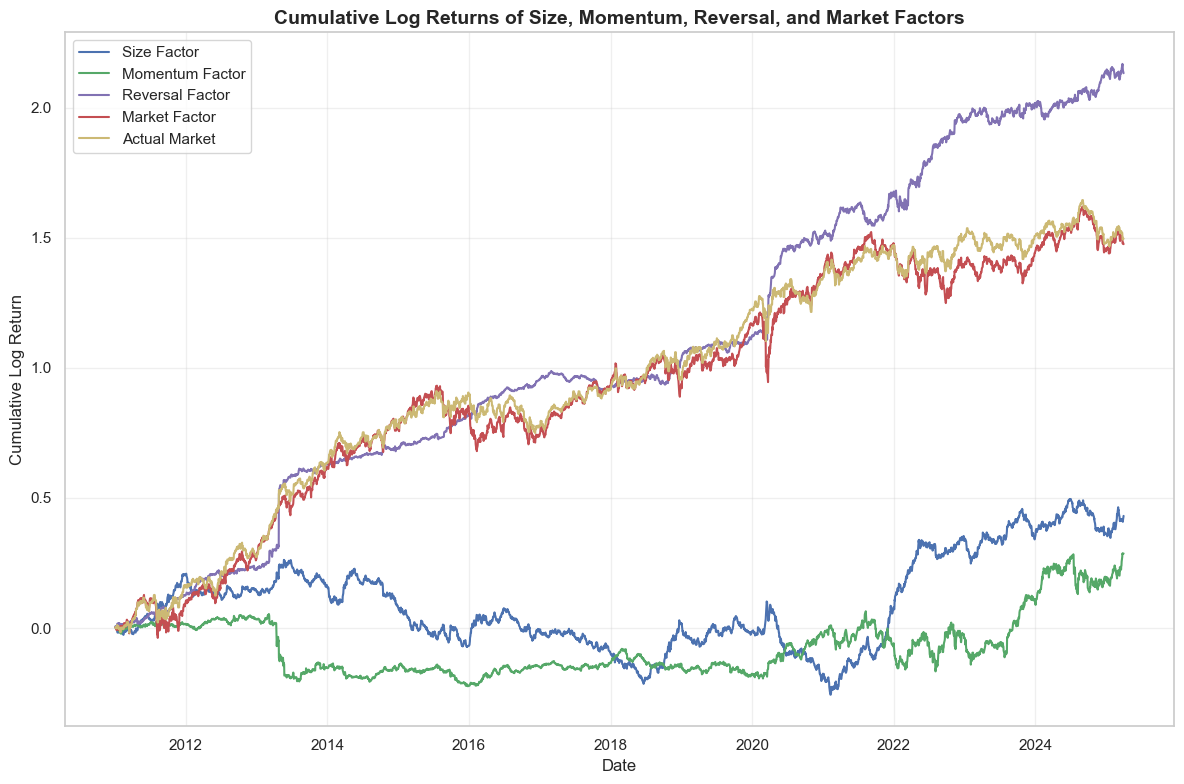

<Figure size 1200x1200 with 0 Axes>

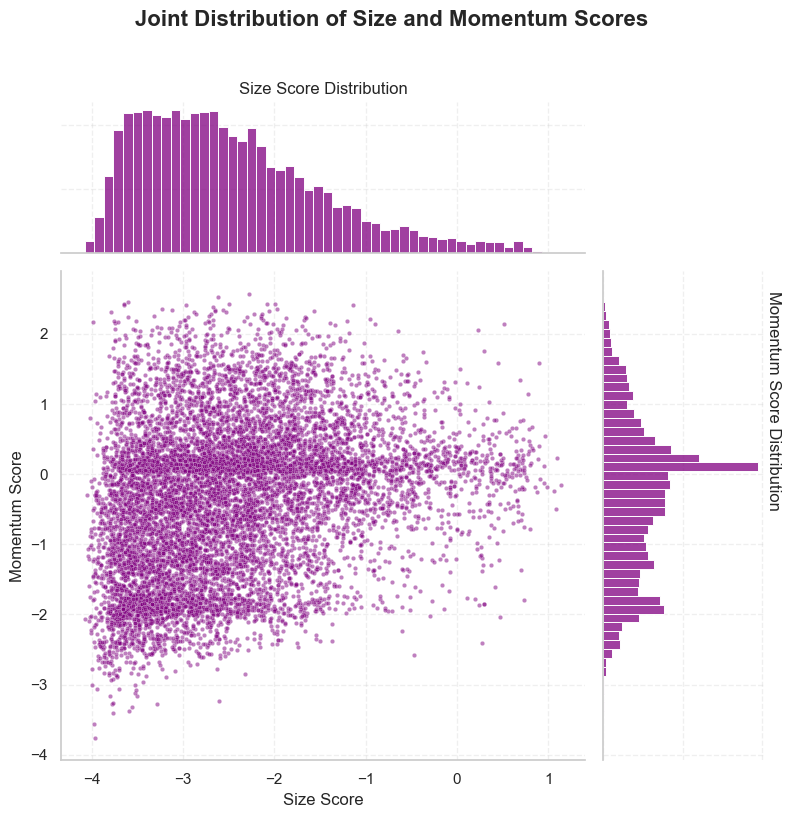

<Figure size 1200x1200 with 0 Axes>

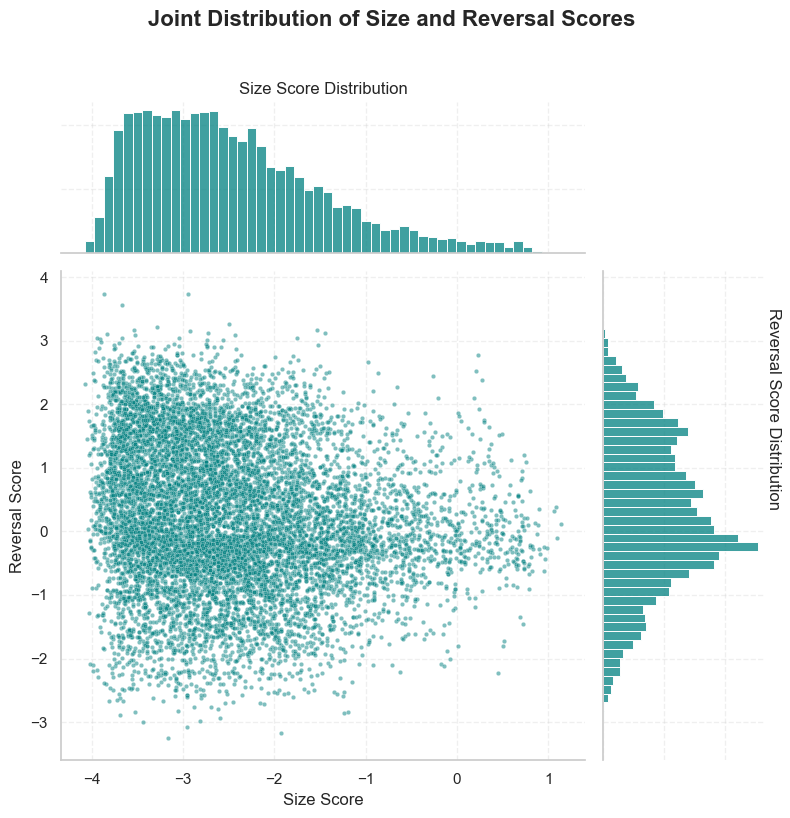

<Figure size 1200x1200 with 0 Axes>

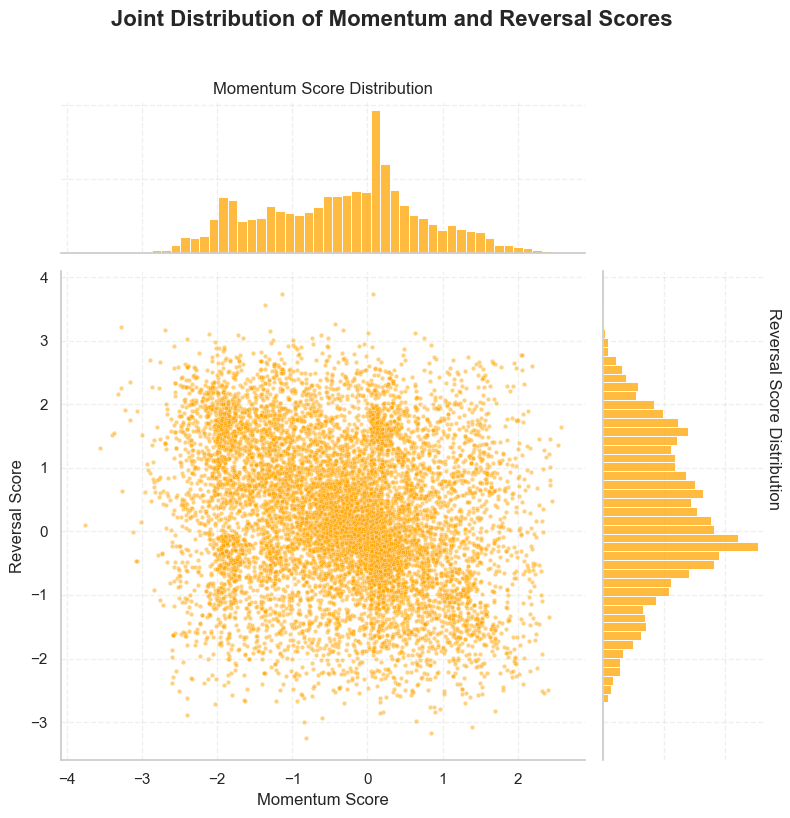

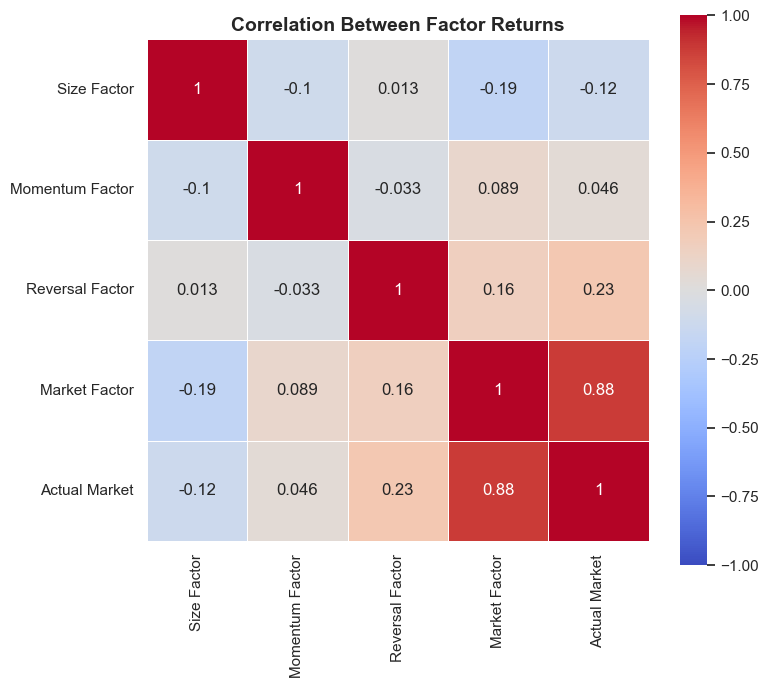

In [772]:
# Plot the cumulative returns of the size factor and market factor
plt.figure(figsize=(1200/100, 800/100))

size_returns = regression_results['Size_Factor_Return'].fillna(0)
momentum_returns = regression_results['Momentum_Factor_Return'].fillna(0)
reversal_returns = regression_results['Reversal_Factor_Return'].fillna(0)
market_returns = regression_results['Market_Factor_Return'].fillna(0)
actual_market_returns = rets.mul(mkt_cap.shift(1)).sum(axis=1).div(mkt_cap.shift(1).sum(axis=1)).fillna(0)
actual_market_returns = actual_market_returns.loc[size_returns.index]

days_per_year = len(size_returns)/((size_returns.index[-1] - size_returns.index[0]).days/365.25)

target_vol = 0.10

size_returns = size_returns * target_vol / (size_returns.std() * np.sqrt(days_per_year))
size_cumulative_returns = np.log(1 + size_returns).cumsum()

momentum_returns = momentum_returns * target_vol / (momentum_returns.std() * np.sqrt(days_per_year))
momentum_cumulative_returns = np.log(1 + momentum_returns).cumsum()

reversal_returns = reversal_returns * target_vol / (reversal_returns.std() * np.sqrt(days_per_year))
reversal_cumulative_returns = np.log(1 + reversal_returns).cumsum()

#print(market_returns.std()*np.sqrt(days_per_year))
#market_returns = market_returns * target_vol / (market_returns.std() * np.sqrt(days_per_year))
market_cumulative_returns = np.log(1 + market_returns).cumsum()
actual_market_cumulative_returns = np.log(1 + actual_market_returns).cumsum()

plt.plot(size_cumulative_returns.index, size_cumulative_returns.values, 'b-', label='Size Factor')
plt.plot(momentum_cumulative_returns.index, momentum_cumulative_returns.values, 'g-', label='Momentum Factor')
plt.plot(reversal_cumulative_returns.index, reversal_cumulative_returns.values, 'm-', label='Reversal Factor')
plt.plot(market_cumulative_returns.index, market_cumulative_returns.values, 'r-', label='Market Factor')
plt.plot(actual_market_cumulative_returns.index, actual_market_cumulative_returns.values, 'y-', label='Actual Market')
plt.title('Cumulative Log Returns of Size, Momentum, Reversal, and Market Factors', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Log Return', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# Create a joint plot with histograms on diagonal and scatter plot at intersection
import seaborn as sns
import pandas as pd
import numpy as np

# First, create the joint plot for size and momentum scores
# Ensure we're working with actual ticker-date pairs
# Convert the DataFrames to long format with actual ticker-date pairs
size_long = size_score.stack().reset_index()
size_long.columns = ['Date', 'Ticker', 'Size Score']

mom_long = momentum_score.stack().reset_index()
mom_long.columns = ['Date', 'Ticker', 'Momentum Score']

reversal_long = reversal_score.stack().reset_index()
reversal_long.columns = ['Date', 'Ticker', 'Reversal Score']

# Merge the DataFrames on Date and Ticker
data = pd.merge(size_long, mom_long, on=['Date', 'Ticker'])
data = pd.merge(data, reversal_long, on=['Date', 'Ticker'])

# Drop any rows with NaN values
data = data.dropna()

# Sample data if there are too many points (for better visualization)
max_points = 10000
if len(data) > max_points:
    data = data.sample(max_points, random_state=42)

# Create the joint plot with seaborn
plt.figure(figsize=(1200/100, 1200/100))
joint_plot = sns.jointplot(
    data=data,
    x='Size Score',
    y='Momentum Score',
    kind='scatter',
    color='purple',
    alpha=0.5,
    s=10,
    height=8,
    ratio=3,
    space=0.1,
    marginal_kws=dict(bins=50, fill=True)
)

# Customize the plot
joint_plot.fig.suptitle('Joint Distribution of Size and Momentum Scores', 
                        fontsize=16, fontweight='bold', y=1.02)

# Customize the scatter plot
joint_plot.ax_joint.grid(True, alpha=0.3, linestyle='--')

# Customize the histograms
joint_plot.ax_marg_x.grid(True, alpha=0.3, linestyle='--')
joint_plot.ax_marg_y.grid(True, alpha=0.3, linestyle='--')
joint_plot.ax_marg_x.set_title('Size Score Distribution', fontsize=12)
joint_plot.ax_marg_y.set_title('Momentum Score Distribution', fontsize=12, rotation=270, x=1.05, y=0.5)

plt.tight_layout()
plt.show()

# Create another joint plot for size and reversal scores
plt.figure(figsize=(1200/100, 1200/100))
joint_plot2 = sns.jointplot(
    data=data,
    x='Size Score',
    y='Reversal Score',
    kind='scatter',
    color='teal',
    alpha=0.5,
    s=10,
    height=8,
    ratio=3,
    space=0.1,
    marginal_kws=dict(bins=50, fill=True)
)

# Customize the plot
joint_plot2.fig.suptitle('Joint Distribution of Size and Reversal Scores', 
                        fontsize=16, fontweight='bold', y=1.02)

# Customize the scatter plot
joint_plot2.ax_joint.grid(True, alpha=0.3, linestyle='--')

# Customize the histograms
joint_plot2.ax_marg_x.grid(True, alpha=0.3, linestyle='--')
joint_plot2.ax_marg_y.grid(True, alpha=0.3, linestyle='--')
joint_plot2.ax_marg_x.set_title('Size Score Distribution', fontsize=12)
joint_plot2.ax_marg_y.set_title('Reversal Score Distribution', fontsize=12, rotation=270, x=1.05, y=0.5)

plt.tight_layout()
plt.show()

# Create a joint plot for momentum and reversal scores
plt.figure(figsize=(1200/100, 1200/100))
joint_plot3 = sns.jointplot(
    data=data,
    x='Momentum Score',
    y='Reversal Score',
    kind='scatter',
    color='orange',
    alpha=0.5,
    s=10,
    height=8,
    ratio=3,
    space=0.1,
    marginal_kws=dict(bins=50, fill=True)
)

# Customize the plot
joint_plot3.fig.suptitle('Joint Distribution of Momentum and Reversal Scores', 
                        fontsize=16, fontweight='bold', y=1.02)

# Customize the scatter plot
joint_plot3.ax_joint.grid(True, alpha=0.3, linestyle='--')

# Customize the histograms
joint_plot3.ax_marg_x.grid(True, alpha=0.3, linestyle='--')
joint_plot3.ax_marg_y.grid(True, alpha=0.3, linestyle='--')
joint_plot3.ax_marg_x.set_title('Momentum Score Distribution', fontsize=12)
joint_plot3.ax_marg_y.set_title('Reversal Score Distribution', fontsize=12, rotation=270, x=1.05, y=0.5)

plt.tight_layout()
plt.show()

# Now create a correlation plot for size, momentum, reversal, and market returns
# Create a DataFrame with the returns
returns_df = pd.DataFrame({
    'Size Factor': size_returns,
    'Momentum Factor': momentum_returns,
    'Reversal Factor': reversal_returns,
    'Market Factor': market_returns,
    'Actual Market': actual_market_returns
})

# Calculate the correlation matrix
corr_matrix = returns_df.corr()

# Create a correlation heatmap
plt.figure(figsize=(800/100, 800/100))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Between Factor Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

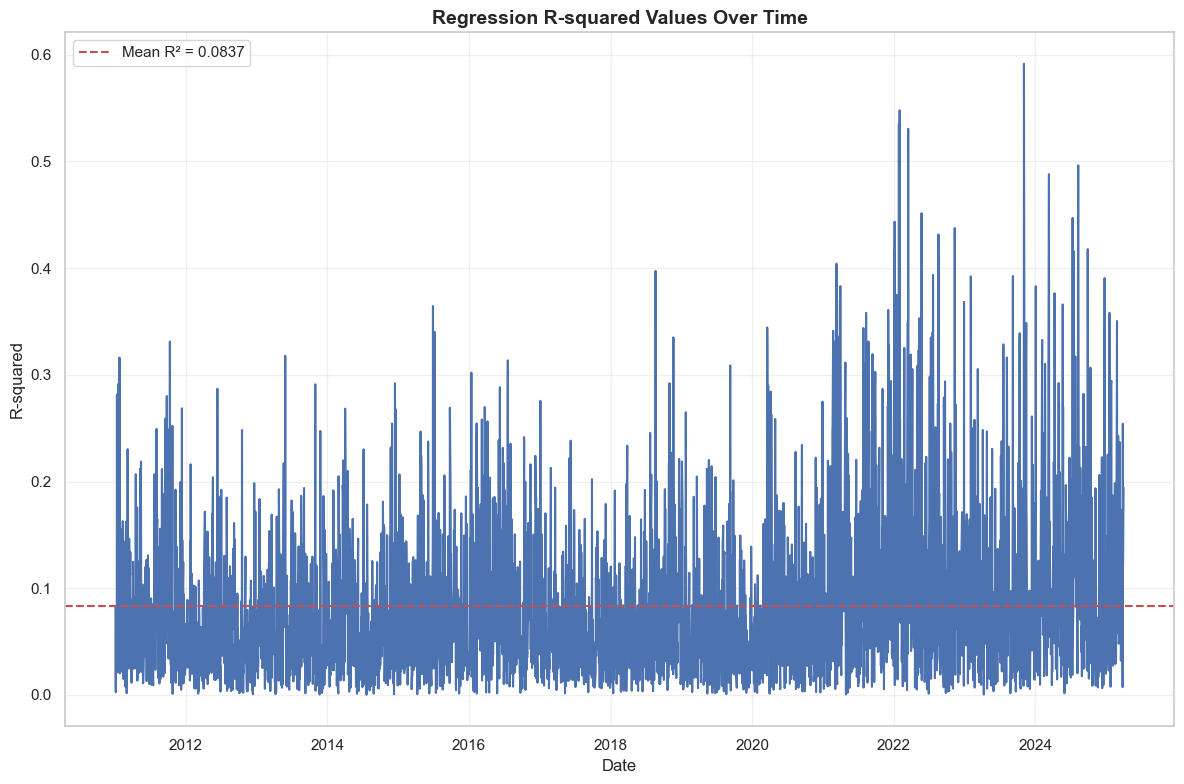

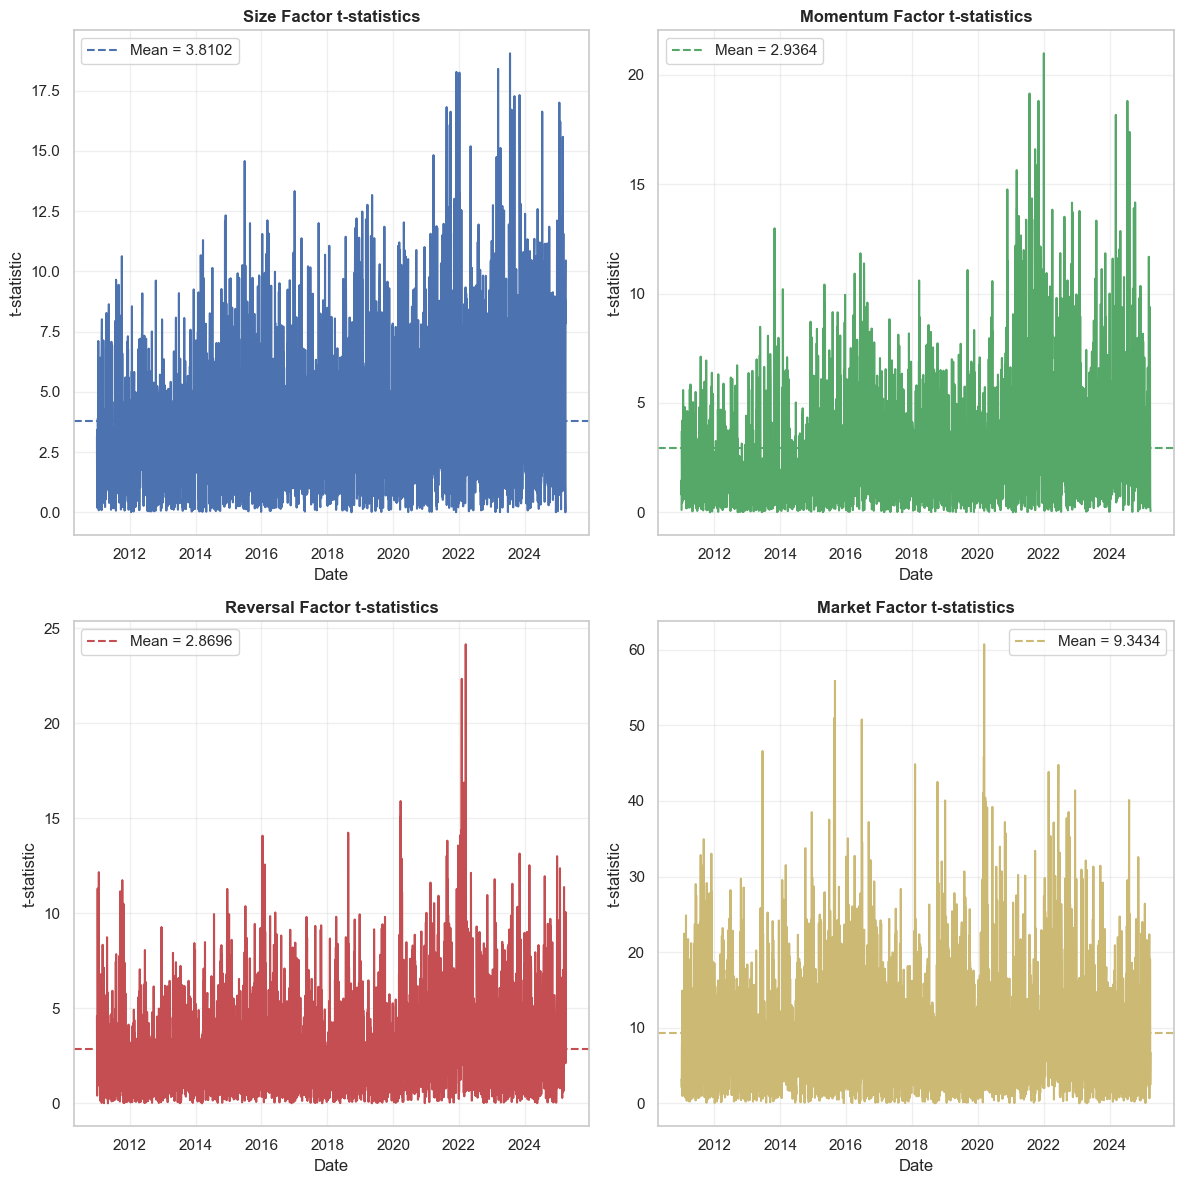

In [773]:
# Plot R-squared values from regression results
plt.figure(figsize=(1200/100, 800/100))

# Extract R-squared values
r_squared_values = regression_results['R_Squared'].dropna()

# Plot R-squared over time
plt.plot(r_squared_values.index, r_squared_values.values, 'b-', linewidth=1.5)
plt.axhline(y=r_squared_values.mean(), color='r', linestyle='--', label=f'Mean R² = {r_squared_values.mean():.4f}')

plt.title('Regression R-squared Values Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('R-squared', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot t-statistics for each factor in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(1200/100, 1200/100))

# Extract t-statistics for each factor
size_tstat = regression_results['Size_T_Stat'].dropna().abs()
momentum_tstat = regression_results['Momentum_T_Stat'].dropna().abs()
reversal_tstat = regression_results['Reversal_T_Stat'].dropna().abs()
market_tstat = regression_results['Market_T_Stat'].dropna().abs()

# Plot Size Factor t-statistics
axs[0, 0].plot(size_tstat.index, size_tstat.values, 'b-', linewidth=1.5)
axs[0, 0].axhline(y=size_tstat.mean(), color='b', linestyle='--', 
                 label=f'Mean = {size_tstat.mean():.4f}')
axs[0, 0].set_title('Size Factor t-statistics', fontweight='bold')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('t-statistic')
axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].legend()

# Plot Momentum Factor t-statistics
axs[0, 1].plot(momentum_tstat.index, momentum_tstat.values, 'g-', linewidth=1.5)
axs[0, 1].axhline(y=momentum_tstat.mean(), color='g', linestyle='--', 
                 label=f'Mean = {momentum_tstat.mean():.4f}')
axs[0, 1].set_title('Momentum Factor t-statistics', fontweight='bold')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('t-statistic')
axs[0, 1].grid(True, alpha=0.3)
axs[0, 1].legend()

# Plot Reversal Factor t-statistics
axs[1, 0].plot(reversal_tstat.index, reversal_tstat.values, 'r-', linewidth=1.5)
axs[1, 0].axhline(y=reversal_tstat.mean(), color='r', linestyle='--', 
                 label=f'Mean = {reversal_tstat.mean():.4f}')
axs[1, 0].set_title('Reversal Factor t-statistics', fontweight='bold')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('t-statistic')
axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].legend()

# Plot Market Factor t-statistics
axs[1, 1].plot(market_tstat.index, market_tstat.values, 'y-', linewidth=1.5)
axs[1, 1].axhline(y=market_tstat.mean(), color='y', linestyle='--', 
                 label=f'Mean = {market_tstat.mean():.4f}')
axs[1, 1].set_title('Market Factor t-statistics', fontweight='bold')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('t-statistic')
axs[1, 1].grid(True, alpha=0.3)
axs[1, 1].legend()

plt.tight_layout()
plt.show()